In [649]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from scipy import misc
import scipy.misc
from scipy import ndimage
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from PIL import Image
from skimage import data, io, util, color, transform, feature, exposure, filters
from skimage.feature import hog

import my_measures 
%matplotlib inline

In [650]:
# file paths/names

root_dir = '/Users/Shirley'

ci_path = root_dir + '/Desktop/plane_data/cropped_images_18/' # cropped images for training
l_file = root_dir + '/Desktop/plane_data/plane_labels_2018.csv' # csv with labels

# get labels and extract features from images

In [651]:
# all labels
plane_data = pd.read_csv(l_file)
print(plane_data.head())
print(plane_data.shape)

                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
(6758, 2)


In [652]:
dims = (60, 140)



(60, 140)
image representation (first row of pixels): 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


example of transformation: 


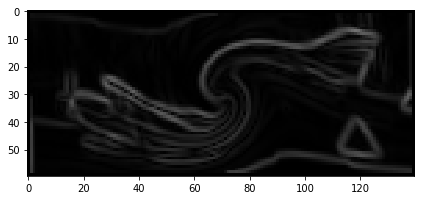

In [653]:
# scikit-image documentation on methods used for feature extraction: 
#    http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray
#    http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
#    http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

def image_manipulation(imname, imview=False):
    warnings.filterwarnings('ignore')
    imname = ci_path + imname + '.png'
    img_raw = io.imread(imname)

    gray = color.rgb2grey(img_raw)
    downscaled = transform.resize(gray, (dims[0], dims[1]))
    swirl = transform.swirl(transform.swirl(transform.swirl(transform.swirl(downscaled))))
    final_image = filters.scharr(swirl)
    
    if imview==True:  
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', True)
#print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

In [654]:
# construct lists for features, labels, and a crosswalk reference to image names

features_list = []
y_list = []
imnames_list = []

for index, row in plane_data.iterrows():
    features_list.append(image_manipulation(row['img_name']))
    y_list.append(row['plane'])
    imnames_list.append(row['img_name'])

### construct lists for features, labels, and a crosswalk reference to image names

features_list = []
y_list = []
imnames_list = []

for index, row in plane_data.iterrows():
    features_list.append(image_manipulation(row['img_name']))
    y_list.append(row['plane'])
    imnames_list.append(row['img_name'])
    

In [655]:
# convert the lists to ndarrays
features = np.asarray(features_list)
Y = np.asarray(y_list)
imgs = np.asarray(imnames_list)
print('Shape of original feature representation: ')
print(features.shape)

# flatten the images ndarray to one row per image
features_flat = features.reshape((features.shape[0], -1))

print('Shape of flat feature representation: ')
print(features_flat.shape)

print('Shape of Y: ')
print(Y.shape)

print('Number of images with planes: ')
print(Y.sum())

Shape of original feature representation: 
(6758, 60, 140)
Shape of flat feature representation: 
(6758, 8400)
Shape of Y: 
(6758,)
Number of images with planes: 
101


In [656]:
# create train and test sets
from sklearn.model_selection import train_test_split

# enter an integer for random_state
data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
    Y, imgs, test_size = 0.25, random_state = 11)

print('Shape of training set: ')
print(y_train.shape)
print('Number of training images that contain an airplane: ')
print(y_train.sum())

print(' ')

print('Shape of test set: ')
print(y_test.shape)
print('Number of test images that contain an airplane: ')
print(y_test.sum())

Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
79
 
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
22


# train Perceptron

In [657]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron', penalty=None, alpha=0.0001, fit_intercept=True, max_iter=None, tol=None, shuffle=True, verbose=0, eta0=1.0, n_jobs=None, random_state=11, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False, n_iter=None)
# prc.fit(data_train, y_train)


prc = joblib.load('prc.pkl')

prc_performance = my_measures.BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = my_measures.BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

/Users/Shirley/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 76, 'TN': 4989, 'FP': 0, 'FN': 3, 'Accuracy': 0.9994080505130228, 'Precision': 1.0, 'Recall': 0.9620253164556962, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 20, 'TN': 1666, 'FP': 2, 'FN': 2, 'Accuracy': 0.9976331360946745, 'Precision': 0.9090909090909091, 'Recall': 0.9090909090909091, 'desc': 'prc', 'set': 'test'}


In [658]:
# joblib.dump(prc, 'prc.pkl')

['prc.pkl']

In [659]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        print(imnames_list[img])
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        #io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


# look at examples of Perceptron classifications

## true positives

2016-08-03T12+32+21_790Z
2016-08-06T20+13+17_820Z
2016-08-07T19+46+51_370Z
2016-08-12T22+15+09_290Z
2016-08-14T19+09+22_710Z
2016-08-22T14+18+14_020Z
2016-08-29T20+57+31_680Z
2016-09-11T14+04+27_740Z
2016-09-14T19+36+44_150Z
2016-09-30T11+35+22_570Z
2016-09-30T15+06+58_170Z
2016-09-30T15+58+12_009Z
2016-10-09T13+46+48_470Z
2016-10-09T14+07+09_170Z
2016-10-21T17+39+42_080Z
2016-10-24T16+32+12_660Z
2016-10-28T16+35+53_050Z
2016-11-11T17+11+50_390Z
2016-11-11T18+38+36_970Z
2016-11-20T20+52+46_960Z


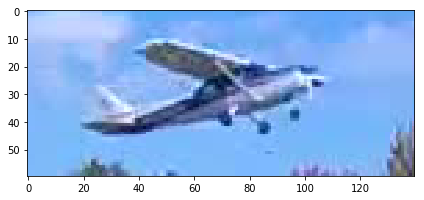

<Figure size 432x288 with 0 Axes>

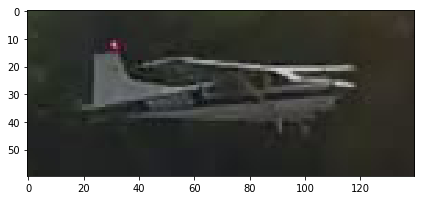

<Figure size 432x288 with 0 Axes>

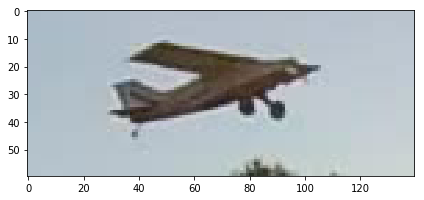

<Figure size 432x288 with 0 Axes>

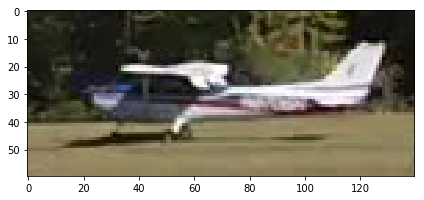

<Figure size 432x288 with 0 Axes>

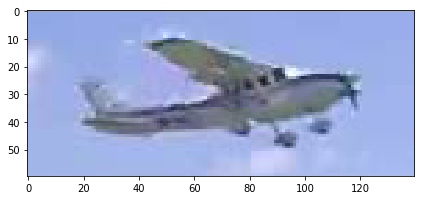

<Figure size 432x288 with 0 Axes>

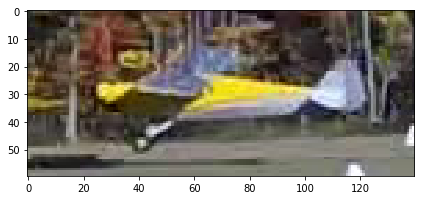

<Figure size 432x288 with 0 Axes>

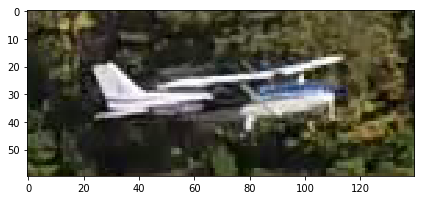

<Figure size 432x288 with 0 Axes>

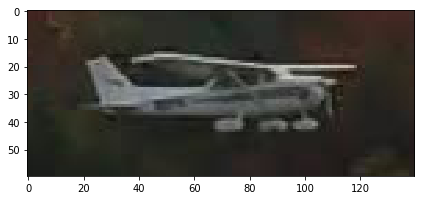

<Figure size 432x288 with 0 Axes>

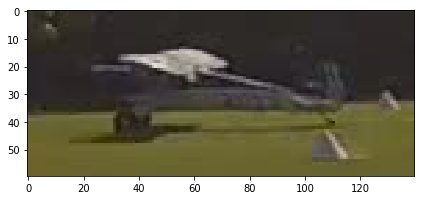

<Figure size 432x288 with 0 Axes>

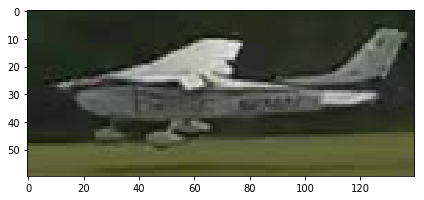

<Figure size 432x288 with 0 Axes>

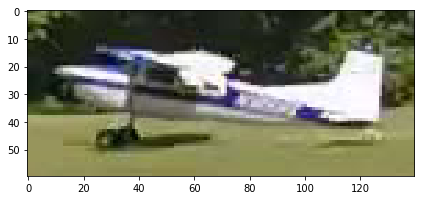

<Figure size 432x288 with 0 Axes>

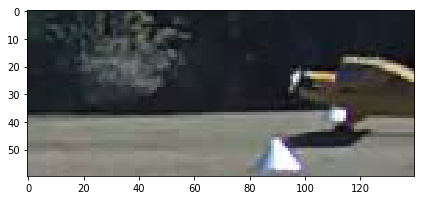

<Figure size 432x288 with 0 Axes>

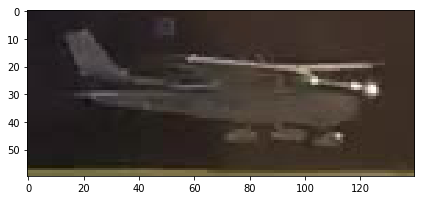

<Figure size 432x288 with 0 Axes>

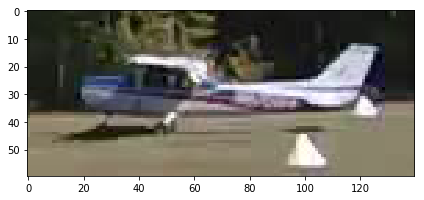

<Figure size 432x288 with 0 Axes>

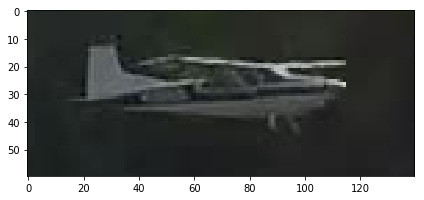

<Figure size 432x288 with 0 Axes>

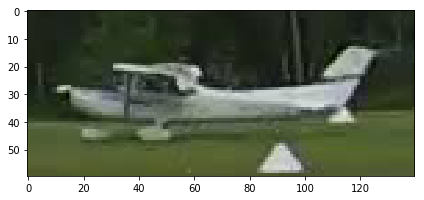

<Figure size 432x288 with 0 Axes>

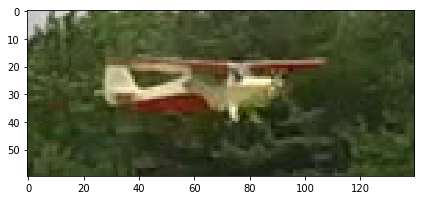

<Figure size 432x288 with 0 Axes>

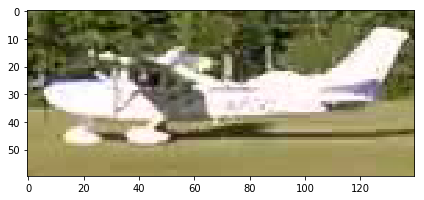

<Figure size 432x288 with 0 Axes>

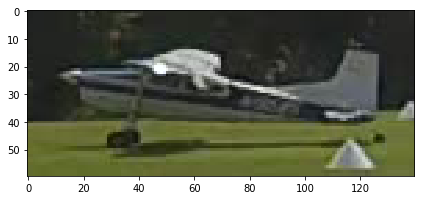

<Figure size 432x288 with 0 Axes>

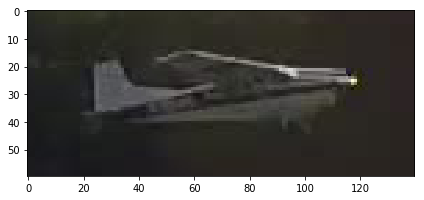

<Figure size 432x288 with 0 Axes>

In [660]:
performance_examples('TP', prc_img_indices_to_view)

## false positives

2016-09-11T14+51+10_100Z
2016-09-13T18+24+24_020Z


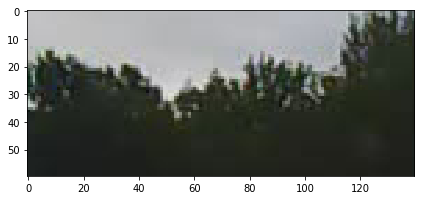

<Figure size 432x288 with 0 Axes>

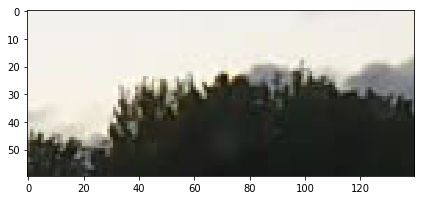

<Figure size 432x288 with 0 Axes>

In [661]:
performance_examples('FP', prc_img_indices_to_view)

## false negatives

In [662]:
#performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

In [663]:
# # MODEL: Multi-layer Perceptron aka neural network
# from sklearn import neural_network
# # nn = neural_network.MLPClassifier(max_iter=1000)

# nn = neural_network.MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
#        beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=(100,10), learning_rate='constant',
#        learning_rate_init=0.001, max_iter=10000, momentum=0.9,
#        n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
#        random_state=None, shuffle=True, solver='adam', tol=0.0001,
#        validation_fraction=0.1, verbose=False, warm_start=False)

# # nn = neural_network.MLPClassifier(activation='relu', alpha=.00001, batch_size='auto', beta_1=0.5,
# #        beta_2=0.999, early_stopping=False, epsilon=1e-08,
# #        hidden_layer_sizes=(1000, 700), learning_rate='constant',
# #        learning_rate_init=0.001, max_iter=5000, momentum=0.5,
# #        n_iter_no_change=10, nesterovs_momentum=True, power_t=0.3,
# #        random_state=None, shuffle=True, solver='adam', tol=0.9,
# #        validation_fraction=0.1, verbose=False, warm_start=False)

# print(nn)
# nn.fit(data_train, y_train)

# nn_performance = my_measures.BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
# nn_performance.compute_measures()
# nn_performance.performance_measures['set'] = 'train'
# print('TRAINING SET: ')
# print(nn_performance.performance_measures)

# nn_performance_test = my_measures.BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
# nn_performance_test.compute_measures()
# nn_performance_test.performance_measures['set'] = 'test'
# print('TEST SET: ')
# print(nn_performance_test.performance_measures)

# nn_performance_test.img_indices()
# nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 79, 'TN': 4989, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 16, 'TN': 1668, 'FP': 0, 'FN': 6, 'Accuracy': 0.9964497041420118, 'Precision': 1.0, 'Recall': 0.7272727272727273, 'desc': 'nn_test', 'set': 'test'}


In [664]:
# joblib.dump(nn, 'nn.pkl')

['nn.pkl']

# look at examples of neural network classifications

## true positives

2016-08-03T12+32+21_790Z
2016-08-06T20+13+17_820Z
2016-08-07T19+46+51_370Z
2016-08-12T22+15+09_290Z
2016-08-29T20+57+31_680Z
2016-09-11T14+04+27_740Z
2016-09-14T19+36+44_150Z
2016-09-30T11+35+22_570Z
2016-09-30T15+06+58_170Z
2016-10-09T13+46+48_470Z
2016-10-09T14+07+09_170Z
2016-10-21T17+39+42_080Z
2016-10-24T16+32+12_660Z
2016-11-11T17+11+50_390Z
2016-11-11T18+38+36_970Z
2016-11-20T20+52+46_960Z


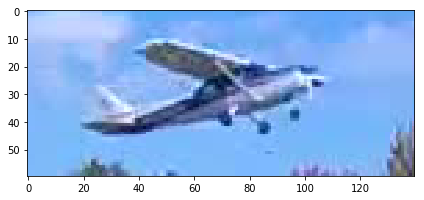

<Figure size 432x288 with 0 Axes>

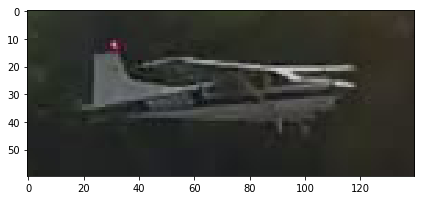

<Figure size 432x288 with 0 Axes>

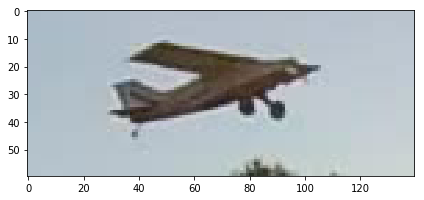

<Figure size 432x288 with 0 Axes>

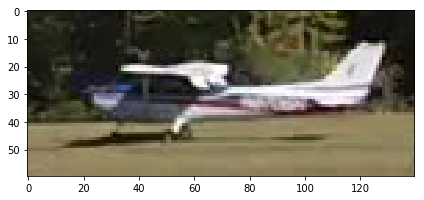

<Figure size 432x288 with 0 Axes>

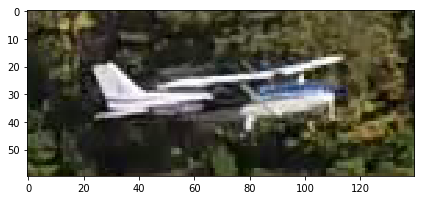

<Figure size 432x288 with 0 Axes>

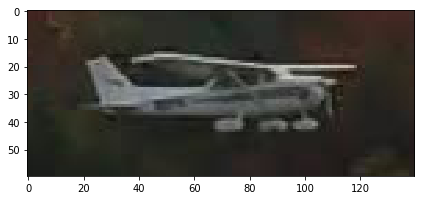

<Figure size 432x288 with 0 Axes>

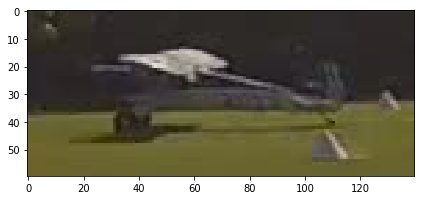

<Figure size 432x288 with 0 Axes>

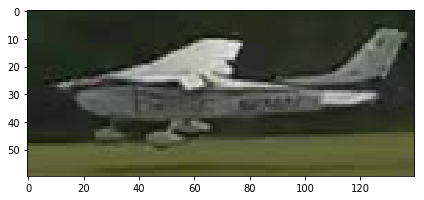

<Figure size 432x288 with 0 Axes>

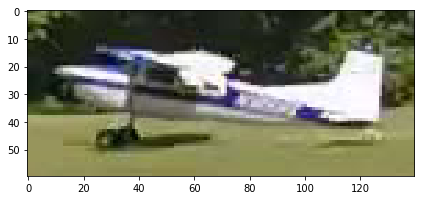

<Figure size 432x288 with 0 Axes>

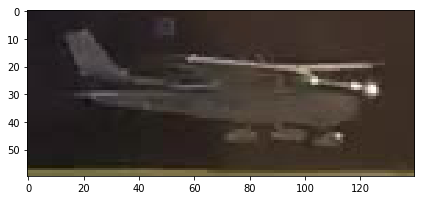

<Figure size 432x288 with 0 Axes>

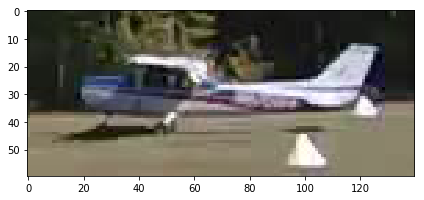

<Figure size 432x288 with 0 Axes>

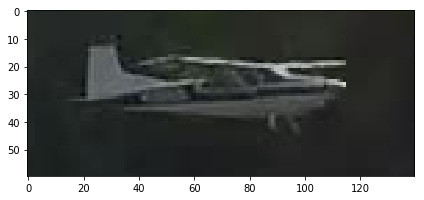

<Figure size 432x288 with 0 Axes>

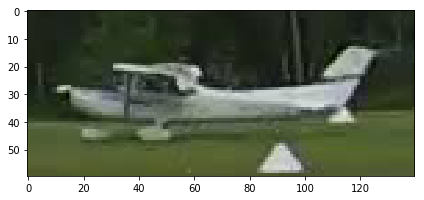

<Figure size 432x288 with 0 Axes>

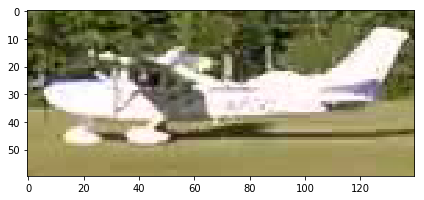

<Figure size 432x288 with 0 Axes>

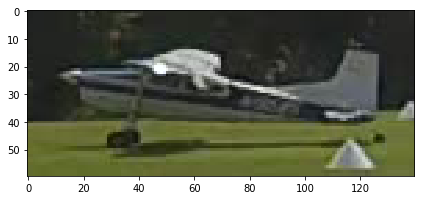

<Figure size 432x288 with 0 Axes>

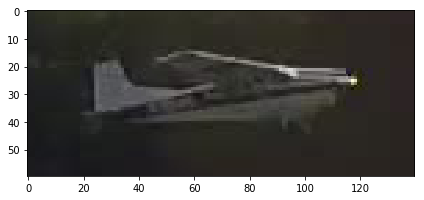

<Figure size 432x288 with 0 Axes>

In [665]:
# performance_examples('TP', nn_img_indices_to_view)

## false positives

In [666]:
# performance_examples('FP', nn_img_indices_to_view)

## false negatives

In [667]:
# performance_examples('FN', nn_img_indices_to_view)

# comparisons

In [668]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)

final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)

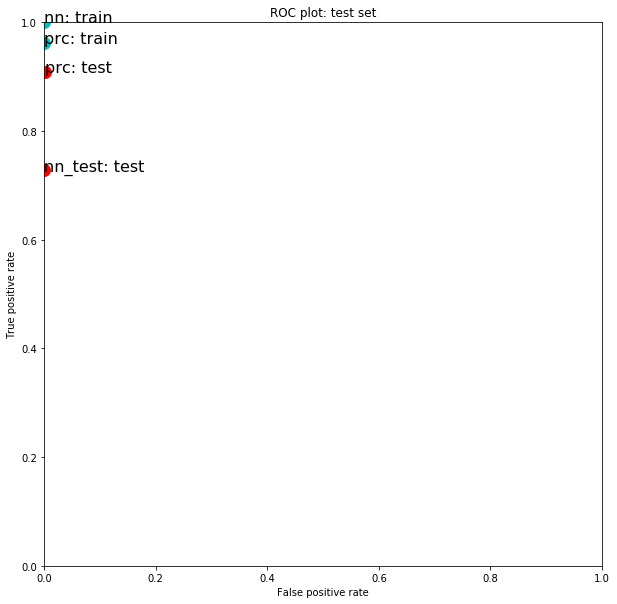

In [669]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')


plt.ylabel('True positive rate')
plt.show()
